In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data Simulation

In [23]:
%run TimeSeriesSimulator.ipynb

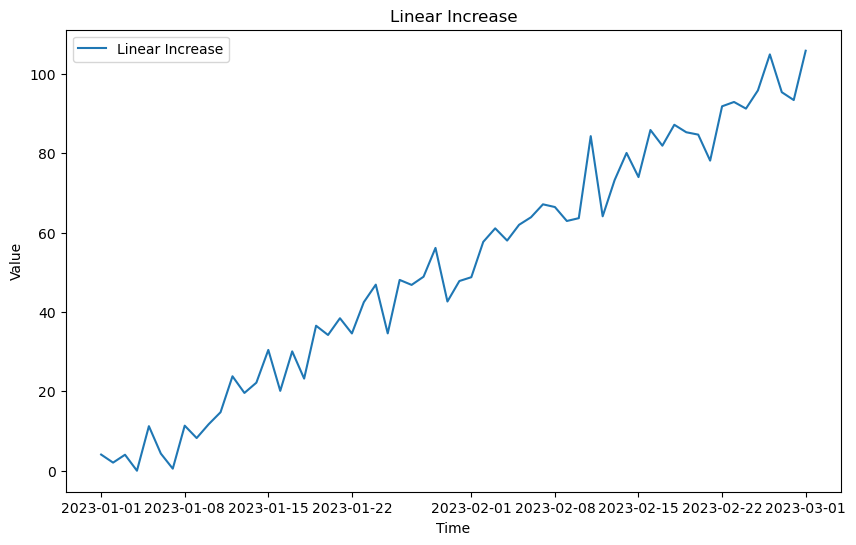

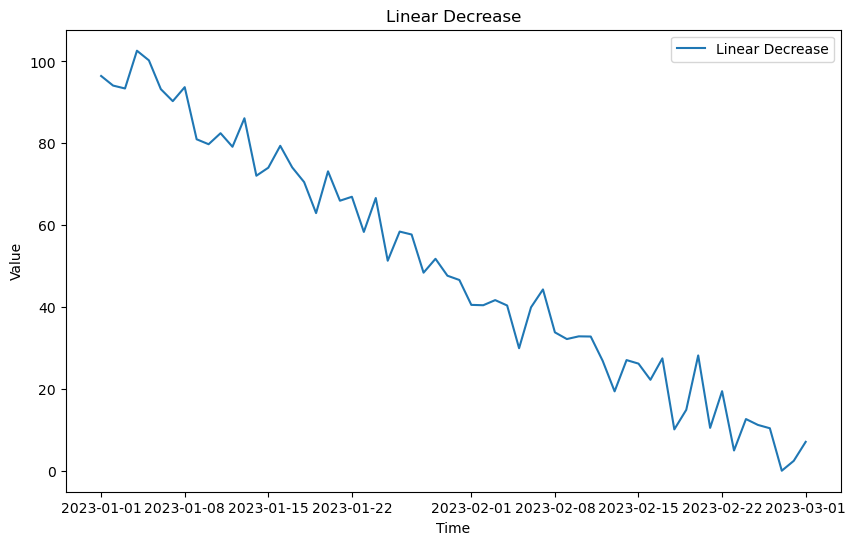

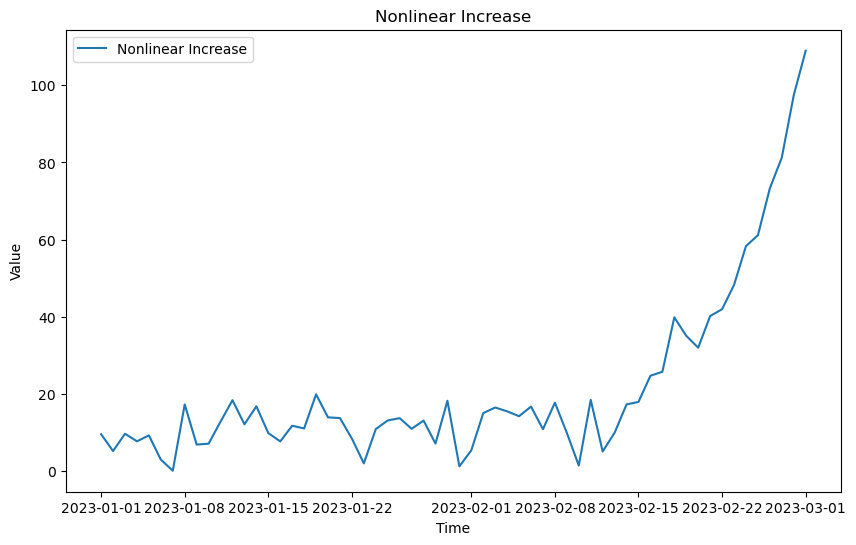

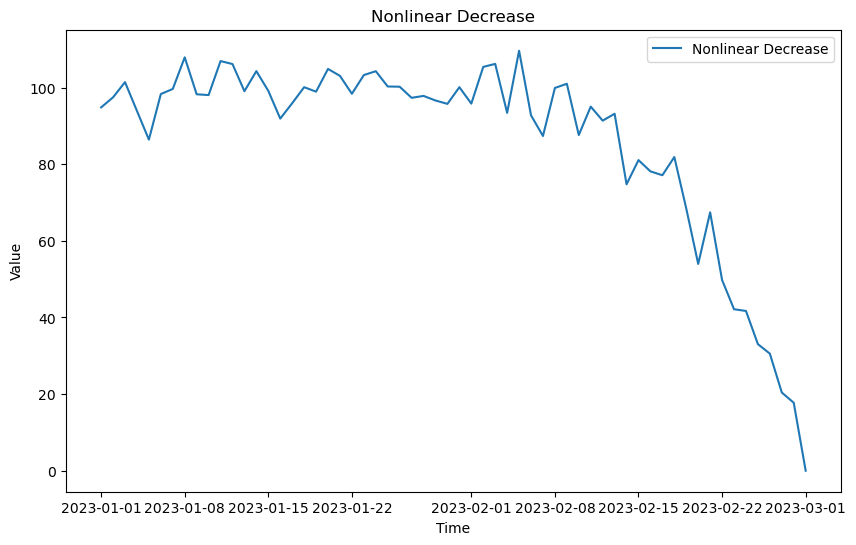

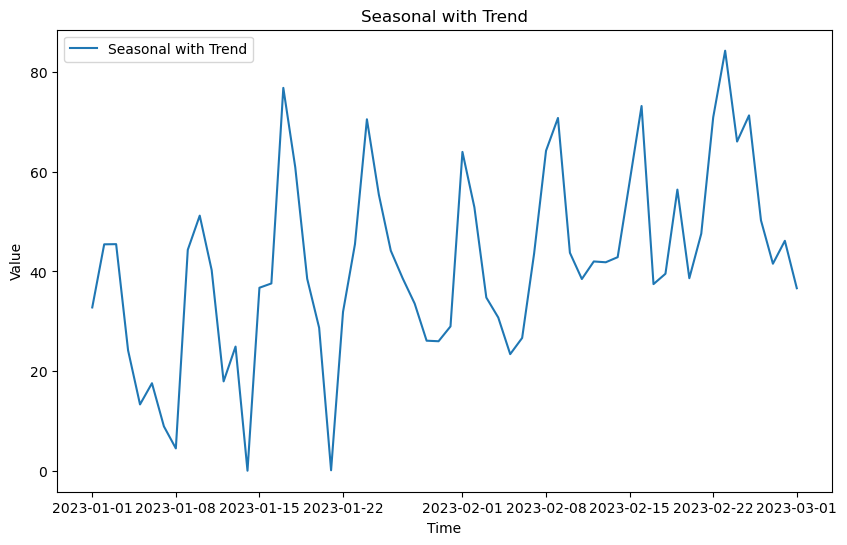

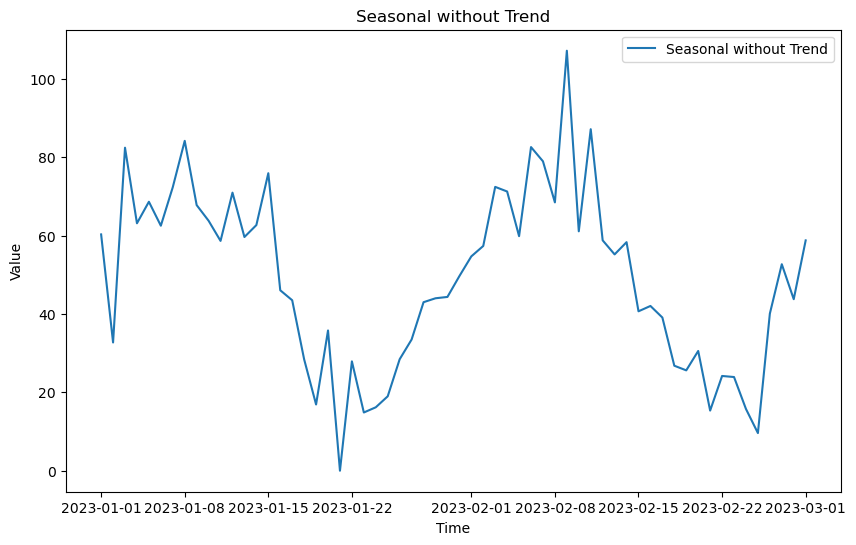

In [34]:
simulator = TimeSeriesSimulator(start='2023-01-01', end='2023-03-01', freq='D')
df_linear_increase = simulator.linear_increase(plot=True, noise_level=5)
df_linear_decrease = simulator.linear_decrease(plot=True, noise_level=5)
df_nonlinear_increase = simulator.nonlinear_increase(exponent=9, plot=True, noise_level=5)
df_nonlinear_decrease = simulator.nonlinear_decrease(exponent=6, plot=True, noise_level=5)
df_seasonal_with_trend = simulator.seasonal_changes_with_trend(amplitude=20, frequency=8, trend_slope=6, plot=True, noise_level=12)
df_seasonal_without_trend = simulator.seasonal_changes_without_trend(amplitude=30, frequency=2, plot=True, noise_level=10)

In [25]:
df_simulated = df_linear_increase
df_simulated[df_linear_decrease.columns[0]] = df_linear_decrease[df_linear_decrease.columns[0]].values
df_simulated[df_nonlinear_increase.columns[0]] = df_nonlinear_increase[df_nonlinear_increase.columns[0]].values
df_simulated[df_nonlinear_decrease.columns[0]] = df_nonlinear_decrease[df_nonlinear_decrease.columns[0]].values
df_simulated[df_seasonal_with_trend.columns[0]] = df_seasonal_with_trend[df_seasonal_with_trend.columns[0]].values
df_simulated[df_seasonal_without_trend.columns[0]] = df_seasonal_without_trend[df_seasonal_without_trend.columns[0]].values
# df_simulated

In [26]:
def smooth_columns(df, columns_to_smooth, window_size=3):
    """
    Smooths specified columns in a pandas DataFrame using a simple moving average.

    Parameters:
    - df: pandas.DataFrame, the DataFrame containing the data.
    - columns_to_smooth: list of str, the names of the columns to smooth.
    - window_size: int, the size of the moving window for the average.

    Returns:
    - The DataFrame with the specified columns smoothed added.
    """
    
    # Apply moving average to each specified column
    for column in columns_to_smooth:
        if column in df.columns:
            df["smoothed_"+column] = df[column].rolling(window=window_size, min_periods=1).mean()
        else:
            print(f"Column '{column}' not found in DataFrame.")
    
    return df

In [27]:
original_cols = df_simulated.columns
df_simulated = smooth_columns(df_simulated, df_simulated.columns)

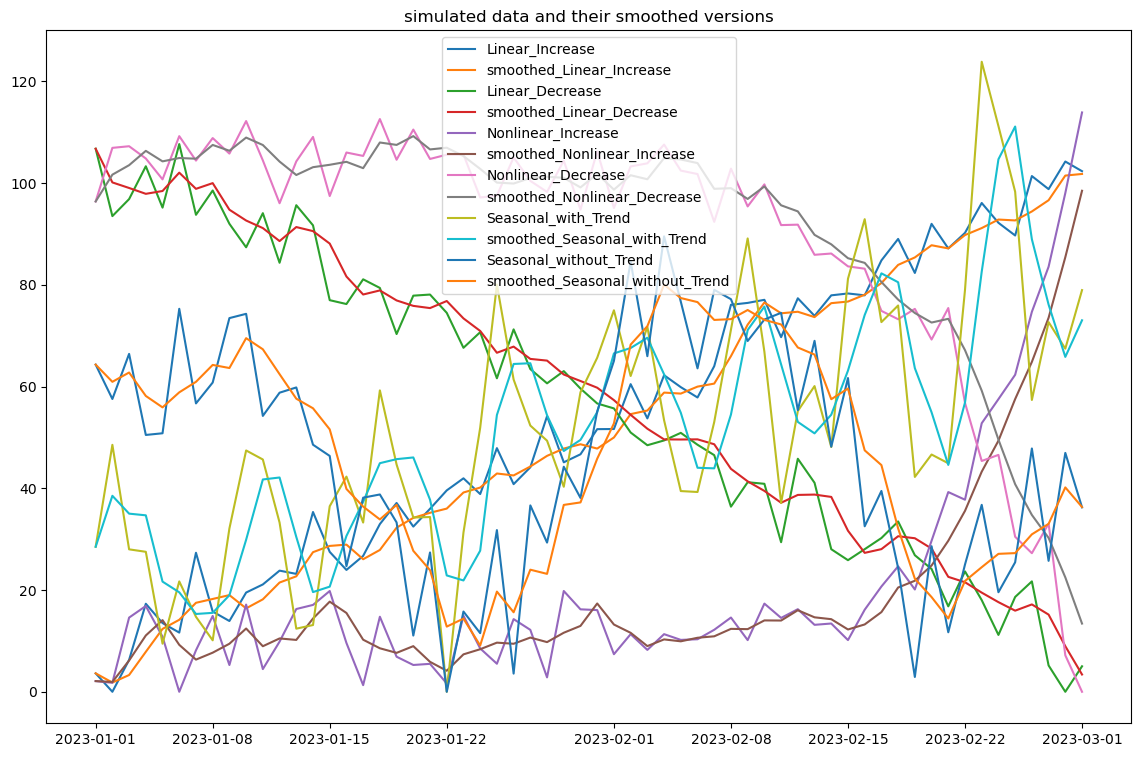

In [28]:
plt.figure(figsize=(14, 9))
for col in original_cols:
    plt.plot(df_simulated[col], label=col)
    plt.plot(df_simulated['smoothed_'+col], label='smoothed_'+col)
plt.title('simulated data and their smoothed versions')
plt.legend()
plt.show()


In [29]:
def underutilized_detect(df, columns_to_check, lu_threshold, target_duration, duration_threshold):
    """
    Detects underutilization in specified columns of a DataFrame.

    This function adds new columns to the DataFrame indicating low usage periods and overall underutilization
    based on the provided threshold and target duration.

    Parameters:
    - df: pandas.DataFrame containing the data.
    - columns_to_check: List of column names to check for underutilization.
    - lu_threshold: Numeric value representing the threshold for low usage.
    - target_duration: The rolling window size (in number of periods) to consider for detecting underutilization.
    - duration_threshold: The minimum number of periods within `target_duration` that must be under `lu_threshold` to be considered underutilized.

    Returns:
    - The DataFrame with added columns indicating low usage and underutilization for each checked column.
    """
    for col in columns_to_check:
        if col in df.columns:
            # Detect low usage intervals
            df['low_usage_'+col] = df[col] < lu_threshold

            # Identifying underutilization
            df['underutilized_'+col] = df['low_usage_'+col].rolling(window=target_duration, min_periods=target_duration).sum() >= duration_threshold
        else:
            print(f"Column '{col}' not found in DataFrame.")

    return df


def overutilized_detect(df, columns_to_check, hu_threshold, target_duration, duration_threshold):
    """
    Detects overutilization in specified columns of a DataFrame.

    This function adds new columns to the DataFrame indicating high usage periods and overall overutilization
    based on the provided threshold and target duration.

    Parameters:
    - df: pandas.DataFrame containing the data.
    - columns_to_check: List of column names to check for overutilization.
    - hu_threshold: Numeric value representing the threshold for high usage.
    - target_duration: The rolling window size (in number of periods) to consider for detecting overutilization.
    - duration_threshold: The minimum number of periods within `target_duration` that must be over `hu_threshold` to be considered overutilized.

    Returns:
    - The DataFrame with added columns indicating high usage and overutilization for each checked column.
    """
    for col in columns_to_check:
        if col in df.columns:
            # Detect high usage intervals
            df['high_usage_'+col] = df[col] > hu_threshold

            # Identifying overutilization
            df['overutilized_'+col] = df['high_usage_'+col].rolling(window=target_duration, min_periods=target_duration).sum() >= duration_threshold
        else:
            print(f"Column '{col}' not found in DataFrame.")

    return df


In [30]:
#### Parameters for underutilized detection
lu_threshold = 40  # Percentage to consider as low usage
target_duration = 4 # time durations to detect underutilization
duration_threshold = 2  # Minimum number of consecutive periods for underutilization

# Parameters for overutilized detection
hu_threshold = 90  # Percentage to consider as high usage
target_duration = 4 # time durations to detect overutilization
duration_threshold = 2  # Minimum number of consecutive periods for overutilization
# Note: duration_threshold <= target_duration

In [31]:
df_simulated = underutilized_detect(df_simulated, ['smoothed_' + col for col in original_cols], lu_threshold, target_duration, duration_threshold)
df_simulated = overutilized_detect(df_simulated, ['smoothed_' + col for col in original_cols], hu_threshold, target_duration, duration_threshold)

In [32]:
def plot_with_highlights(df, columns_and_labels, highlight_column, xlabel=None, ylabel=None, title=None, highlight_color='orange'):
    """
    Plots specified columns of a DataFrame and highlights sections based on a condition.
    
    Parameters:
    - df: pandas.DataFrame containing the data.
    - columns_and_labels: list of tuples, where each tuple contains the column name and its label for the plot.
    - highlight_column: string, the name of the column used to determine sections to highlight.
    - xlabel: string, label for the x-axis. Default is None.
    - ylabel: string, label for the y-axis. Default is None.
    - title: string, title of the plot. Default is None.
    - highlight_color: string, color for the highlights. Default is Orange.
    """
    plt.figure(figsize=(14, 9))
    
    # Plot each specified column
    for column, label in columns_and_labels:
        plt.plot(df[column], label=label)
    
    # Assuming the index is already in a datetime format
    df['date'] = df.index
    
    # Highlight sections
    highlight_indices = df.index[df[highlight_column] == True].tolist()
    for i in range(len(highlight_indices)):
        start = highlight_indices[i]
        loc = df.index.get_loc(start)
        if loc + 1 < len(df.index):
            next_index = df.index[loc + 1]
            plt.axvspan(df['date'][start], df['date'][next_index], color=highlight_color, alpha=0.5)
    
    # Axis and plot formatting
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))  # Limit the number of x-axis labels
    plt.xticks(rotation=45)
    
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    
    plt.legend()
    plt.tight_layout()
    plt.show()


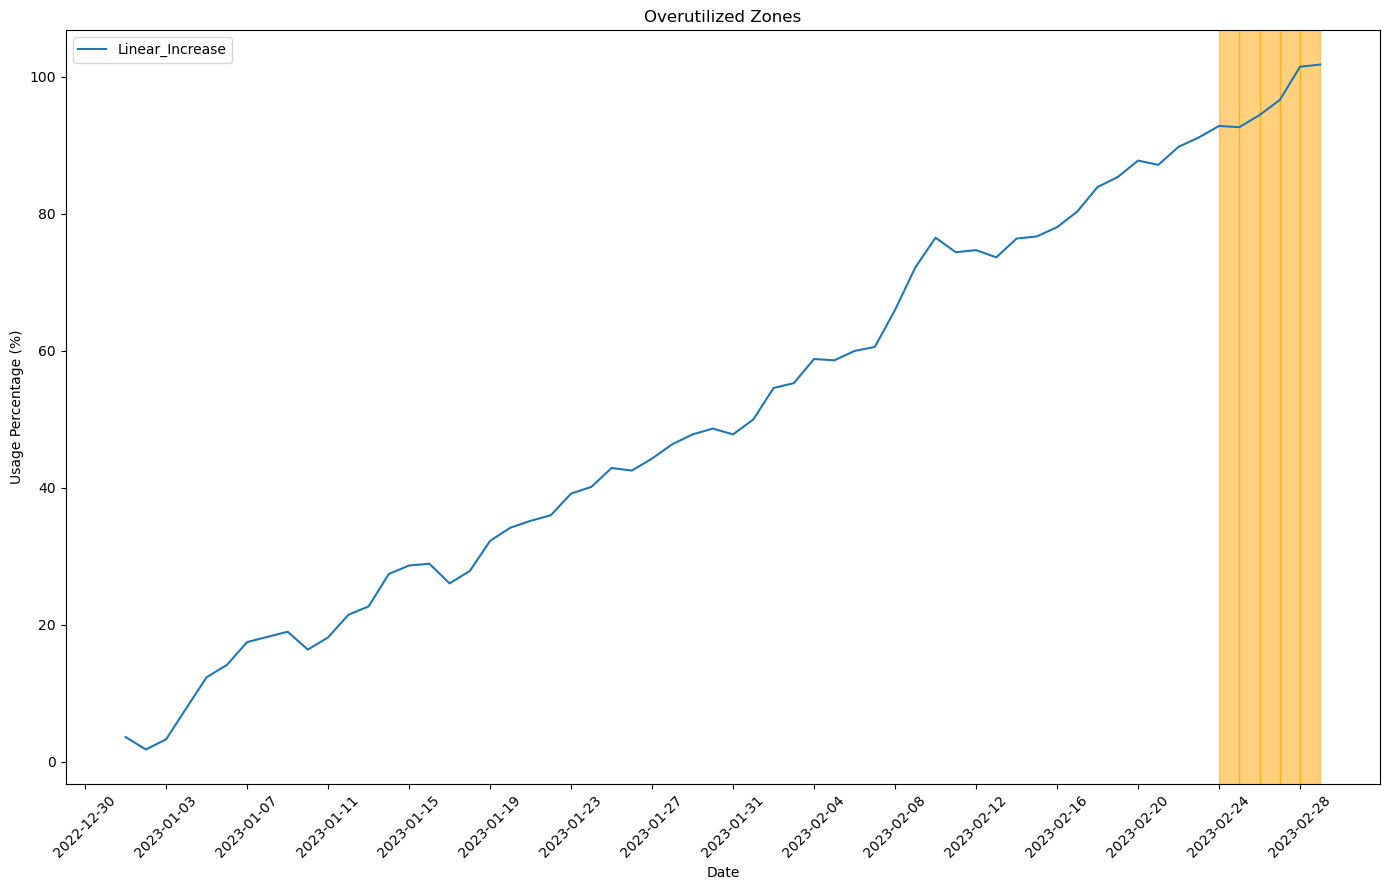

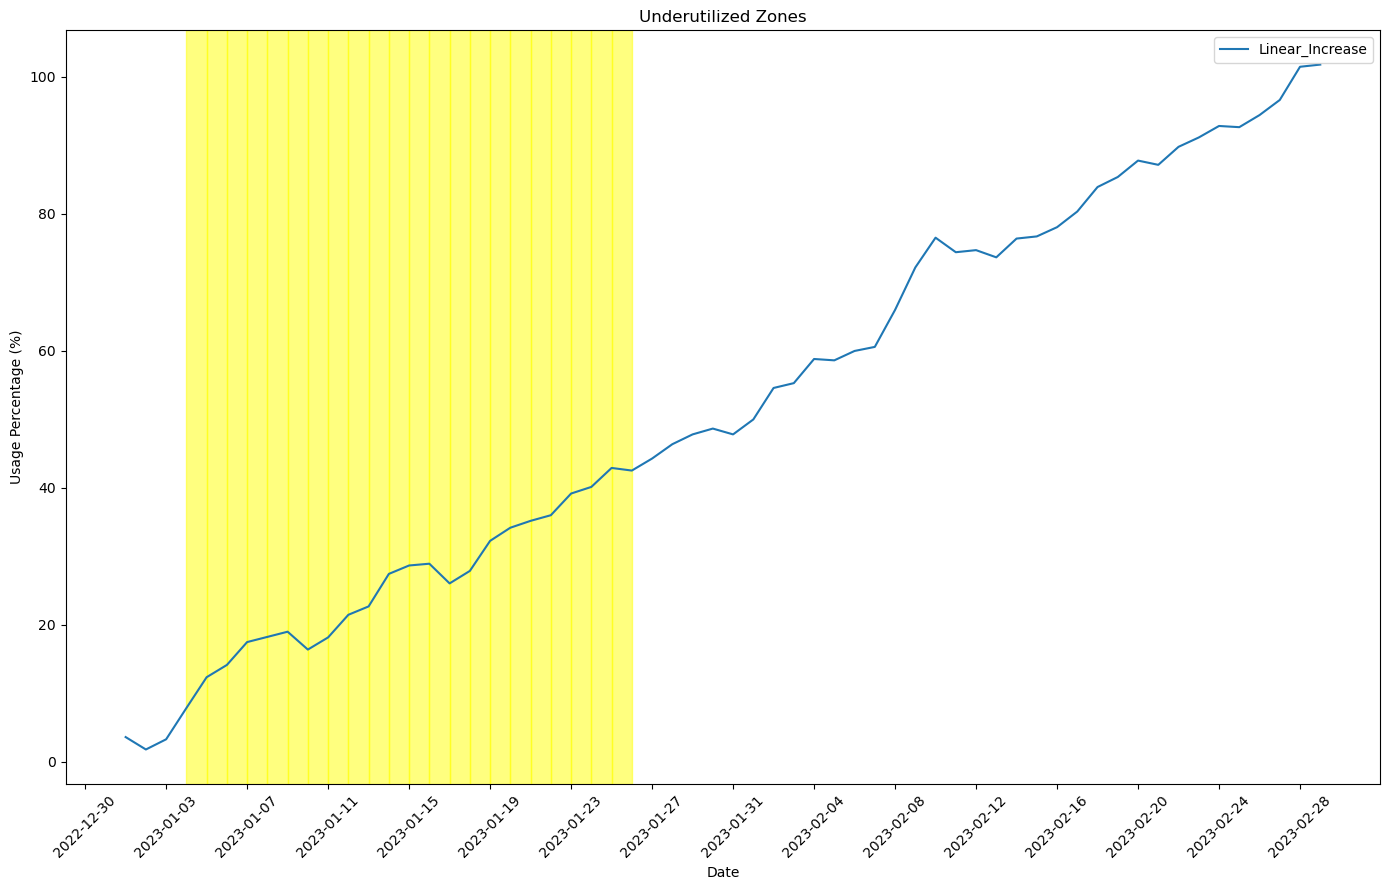

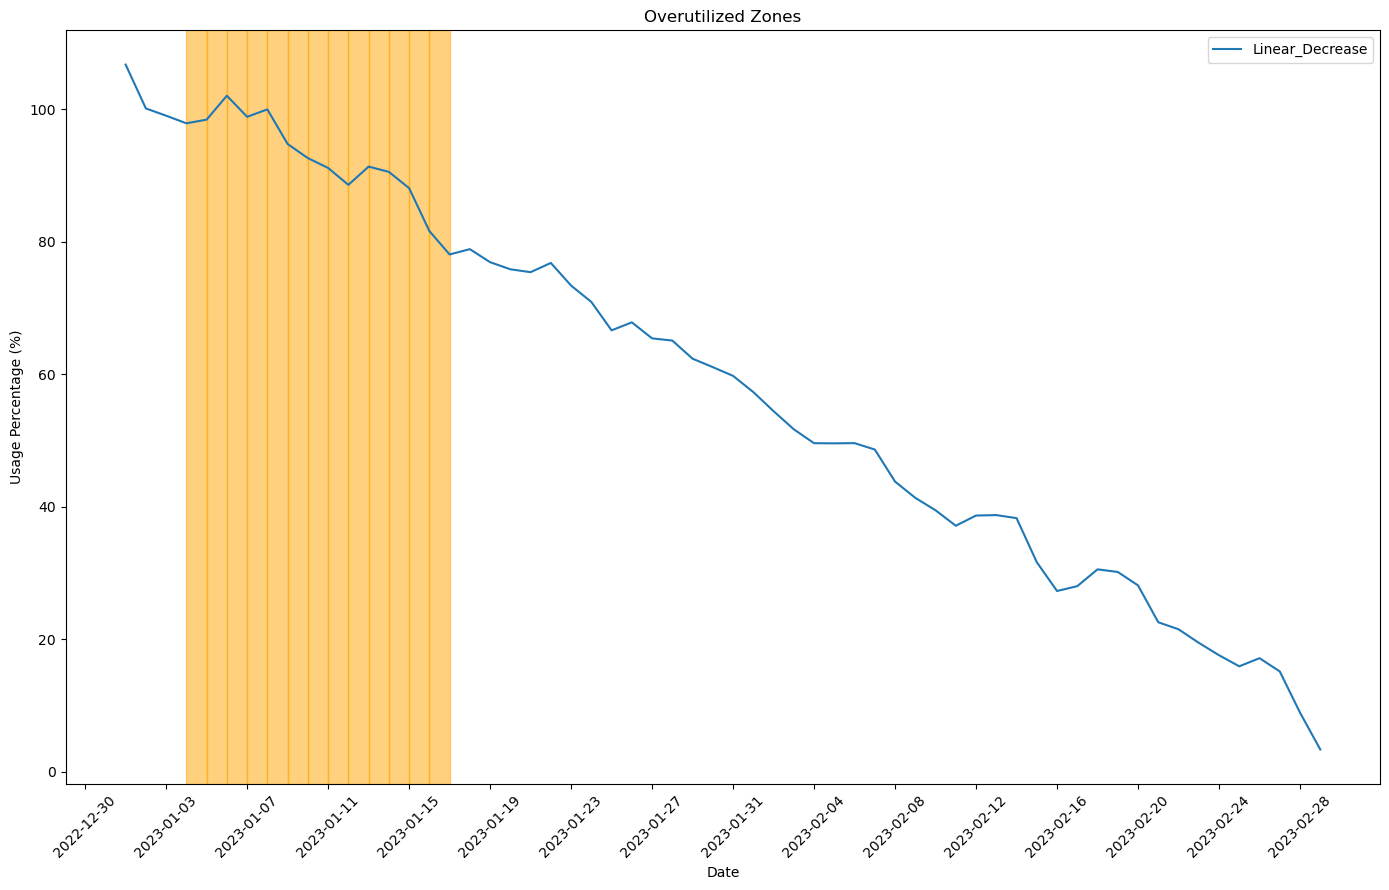

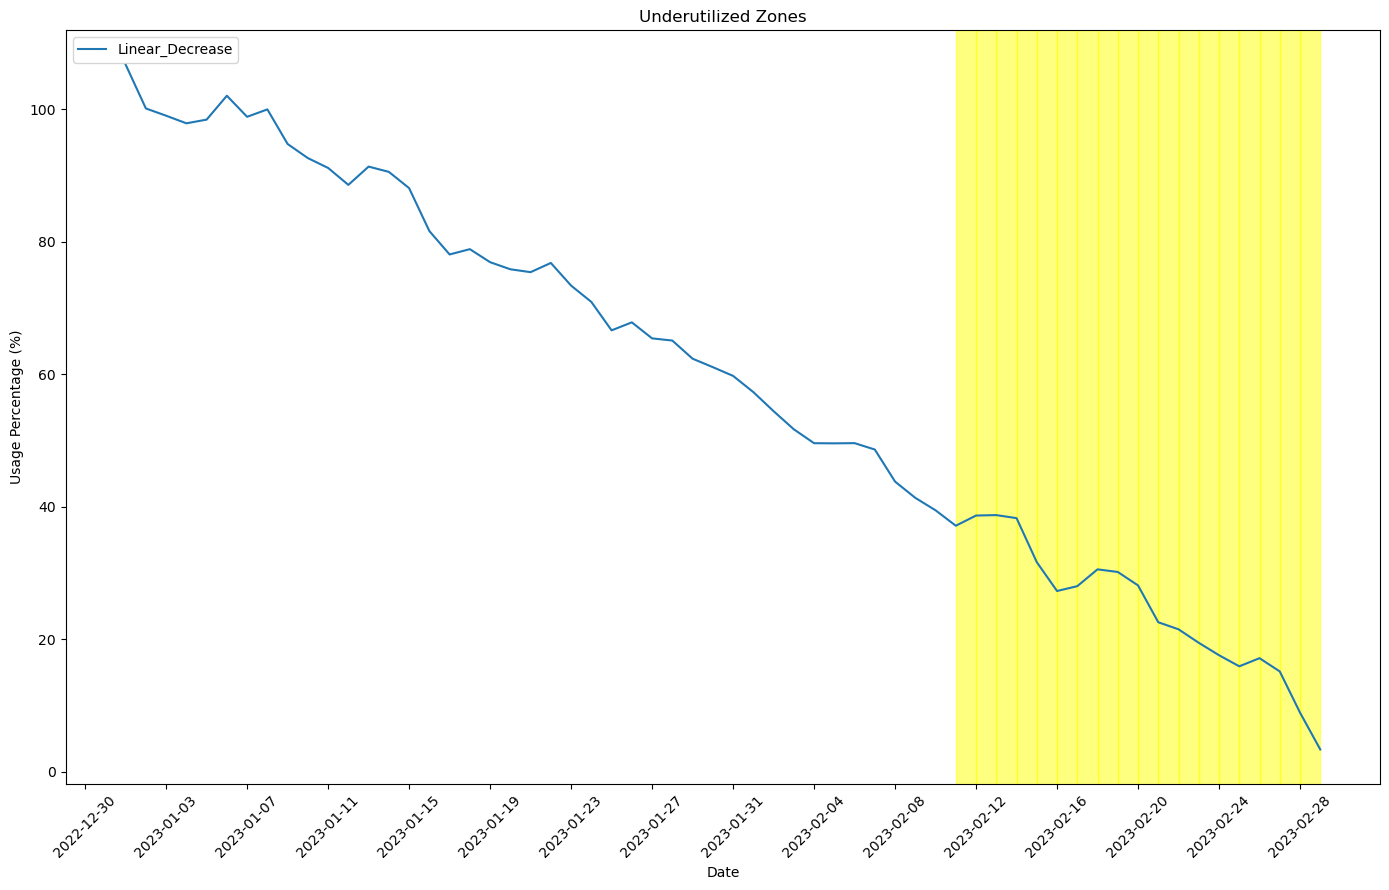

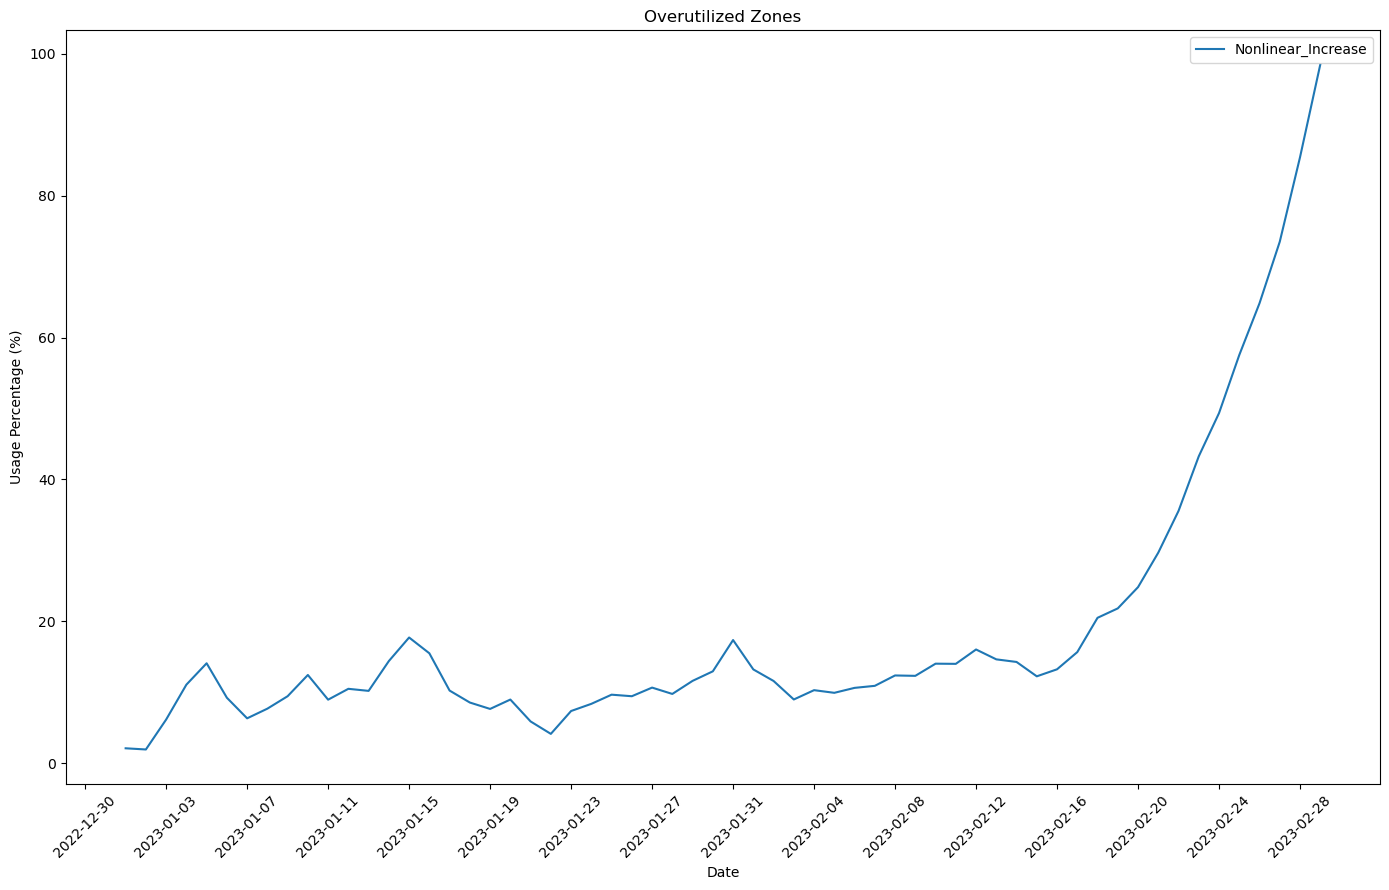

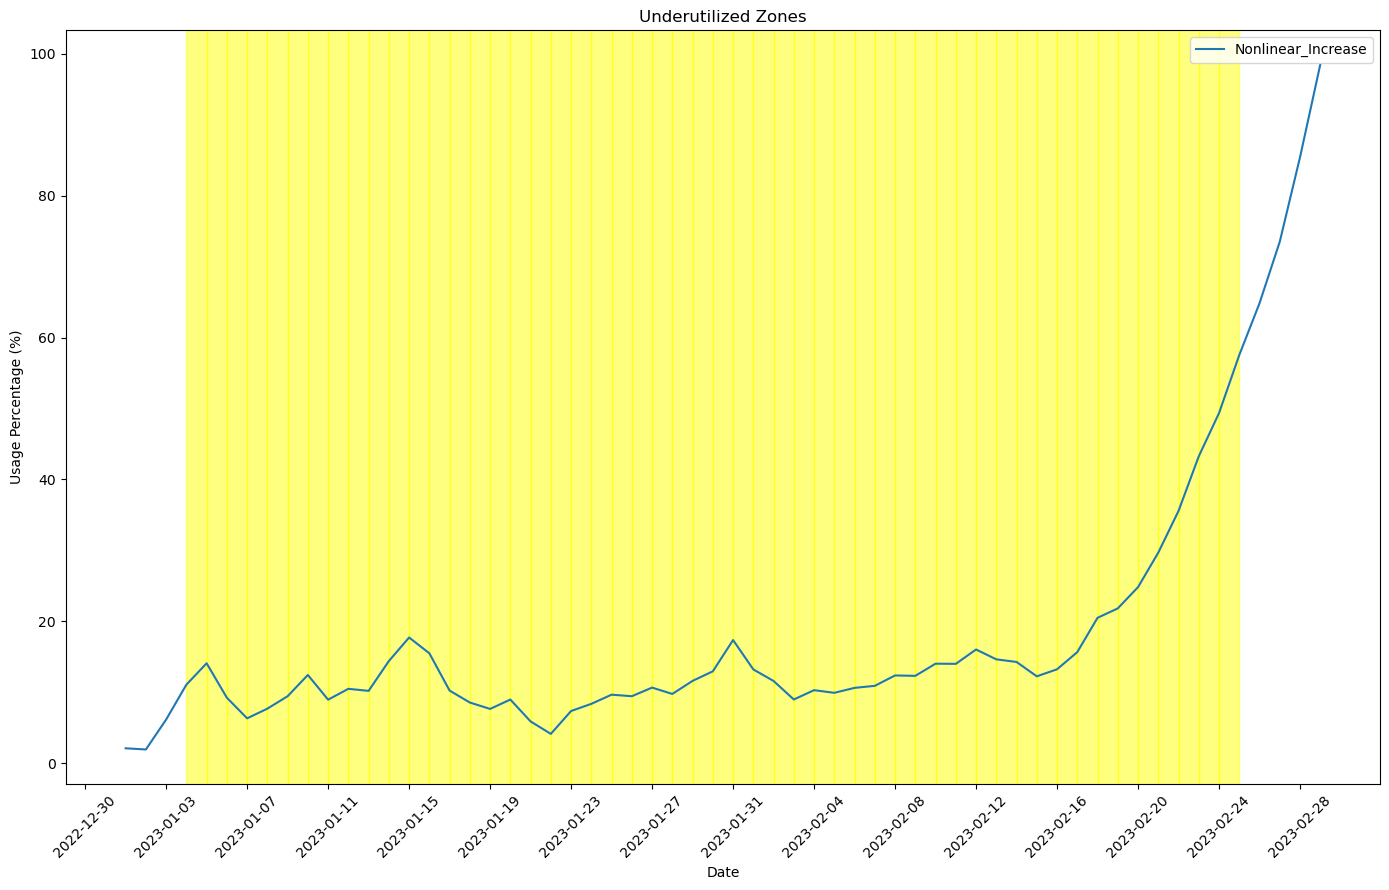

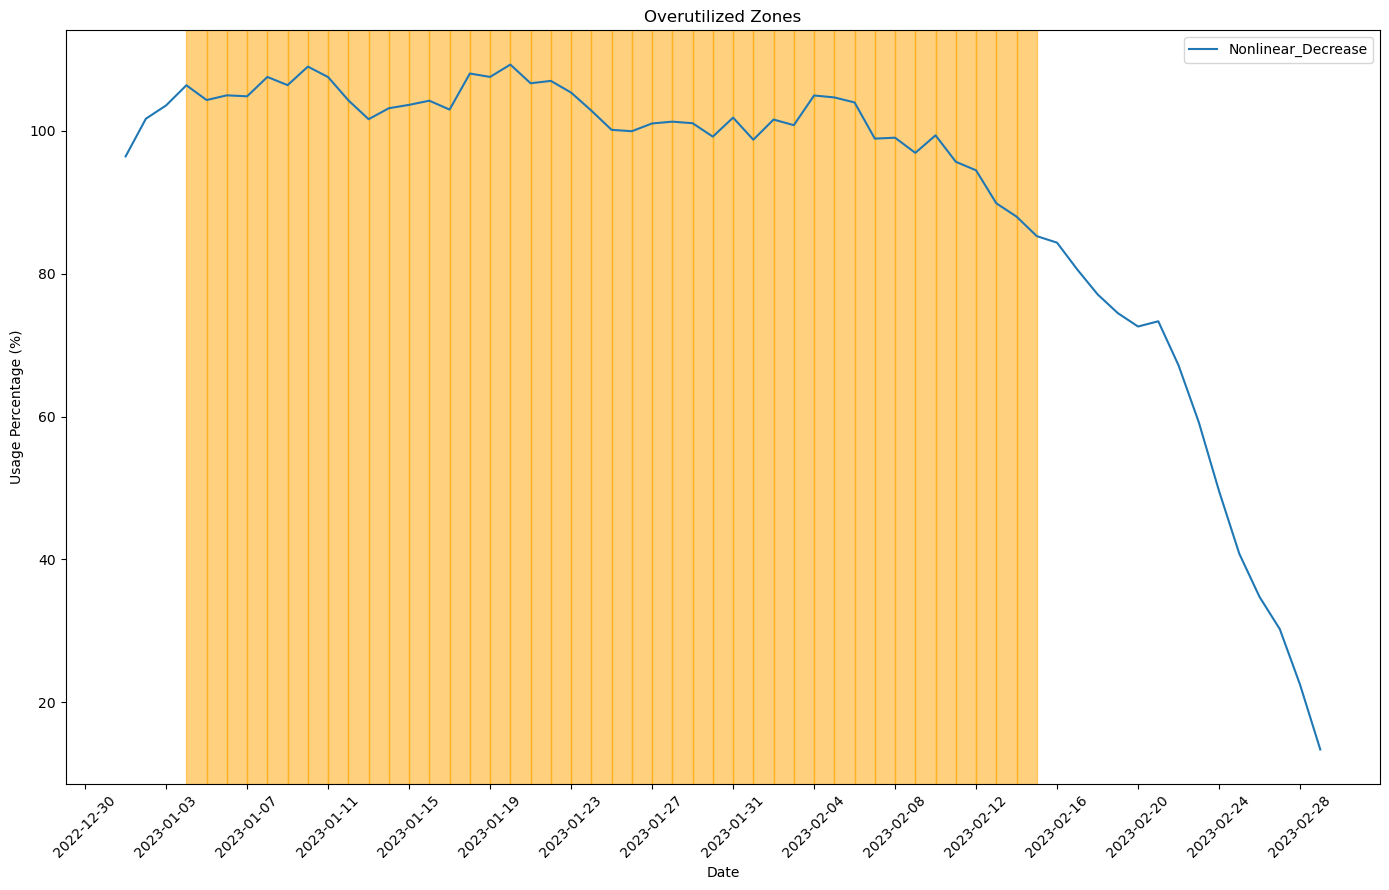

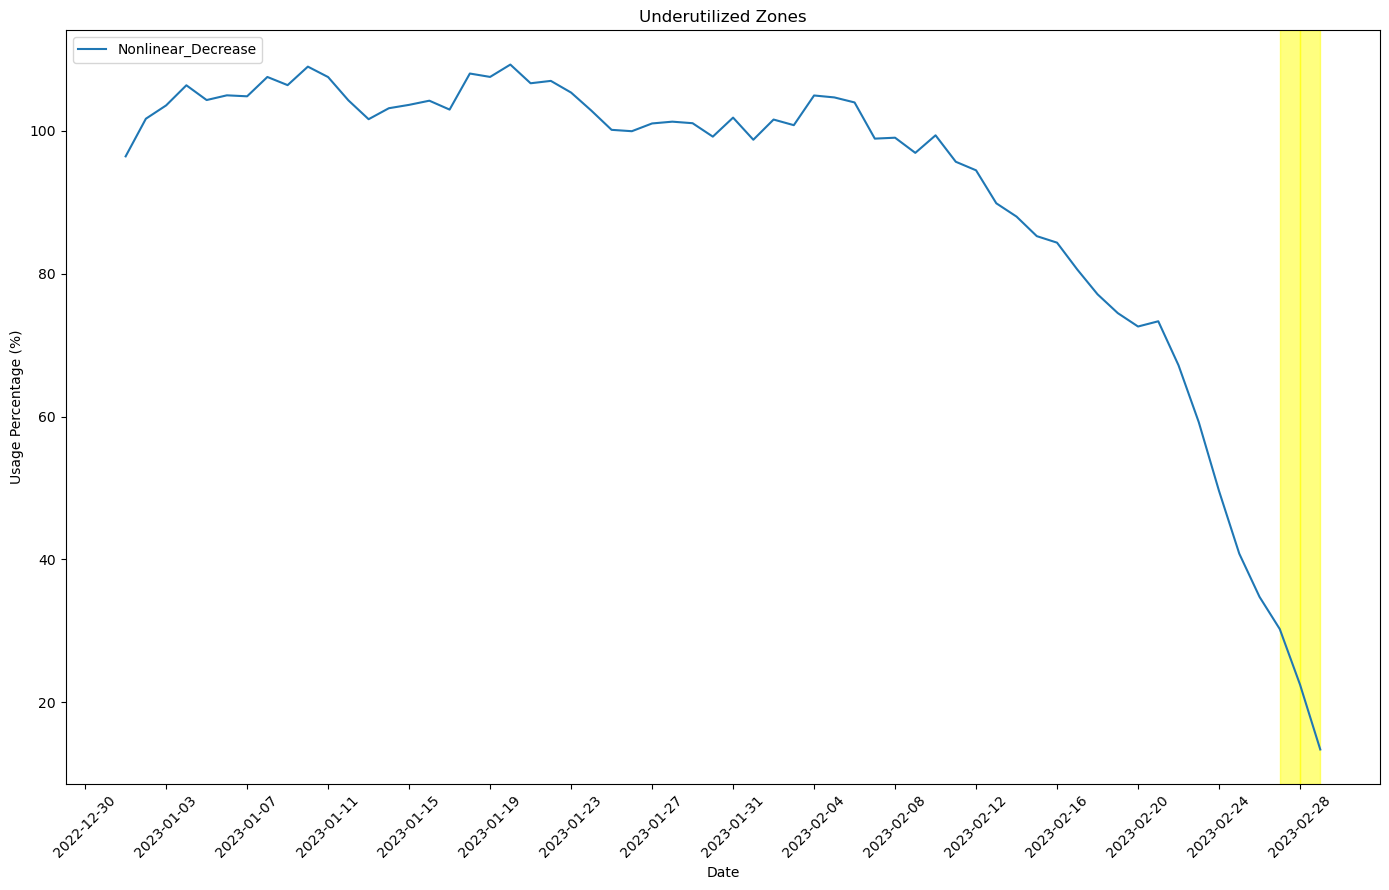

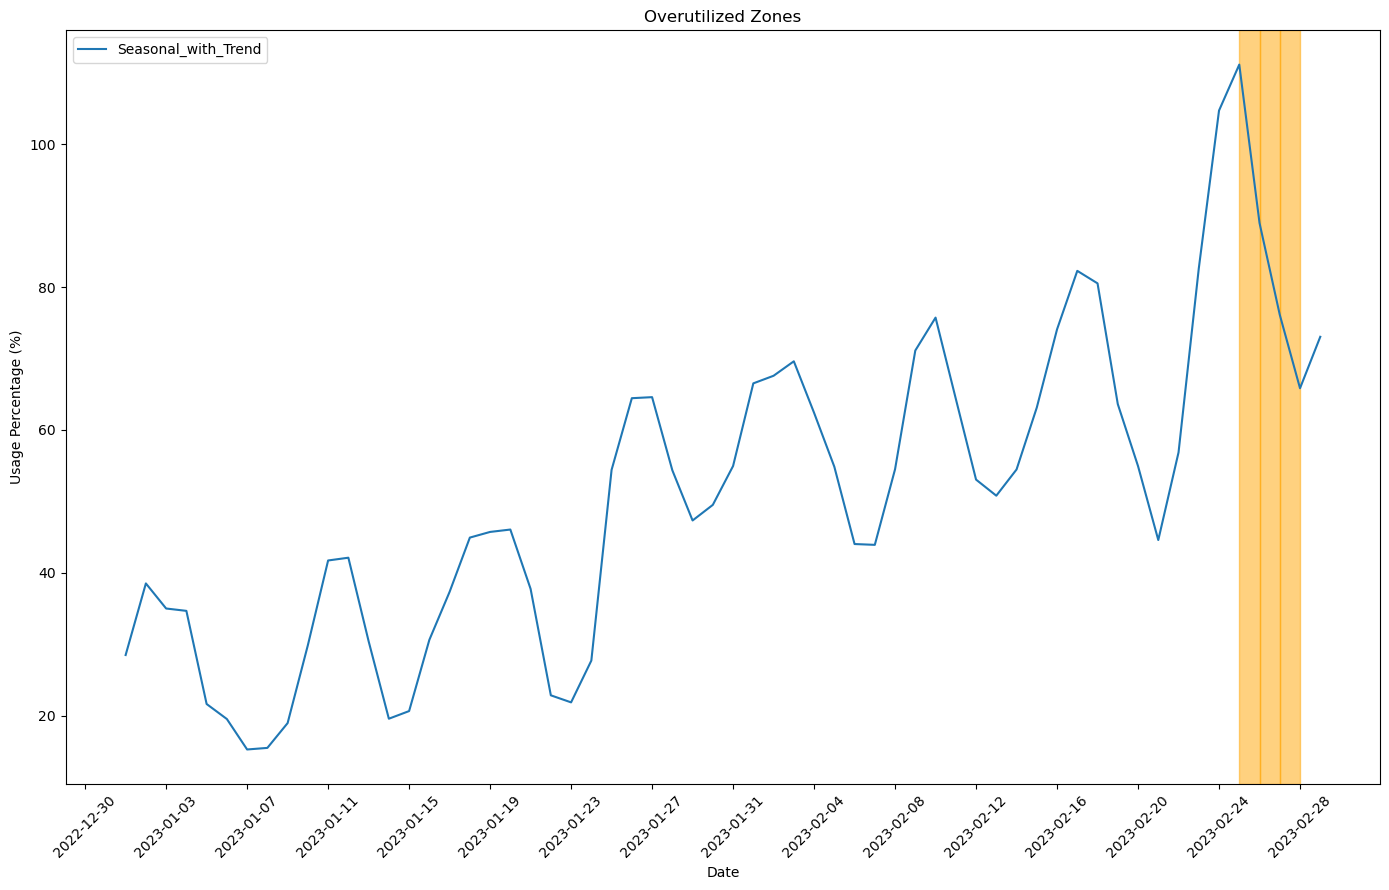

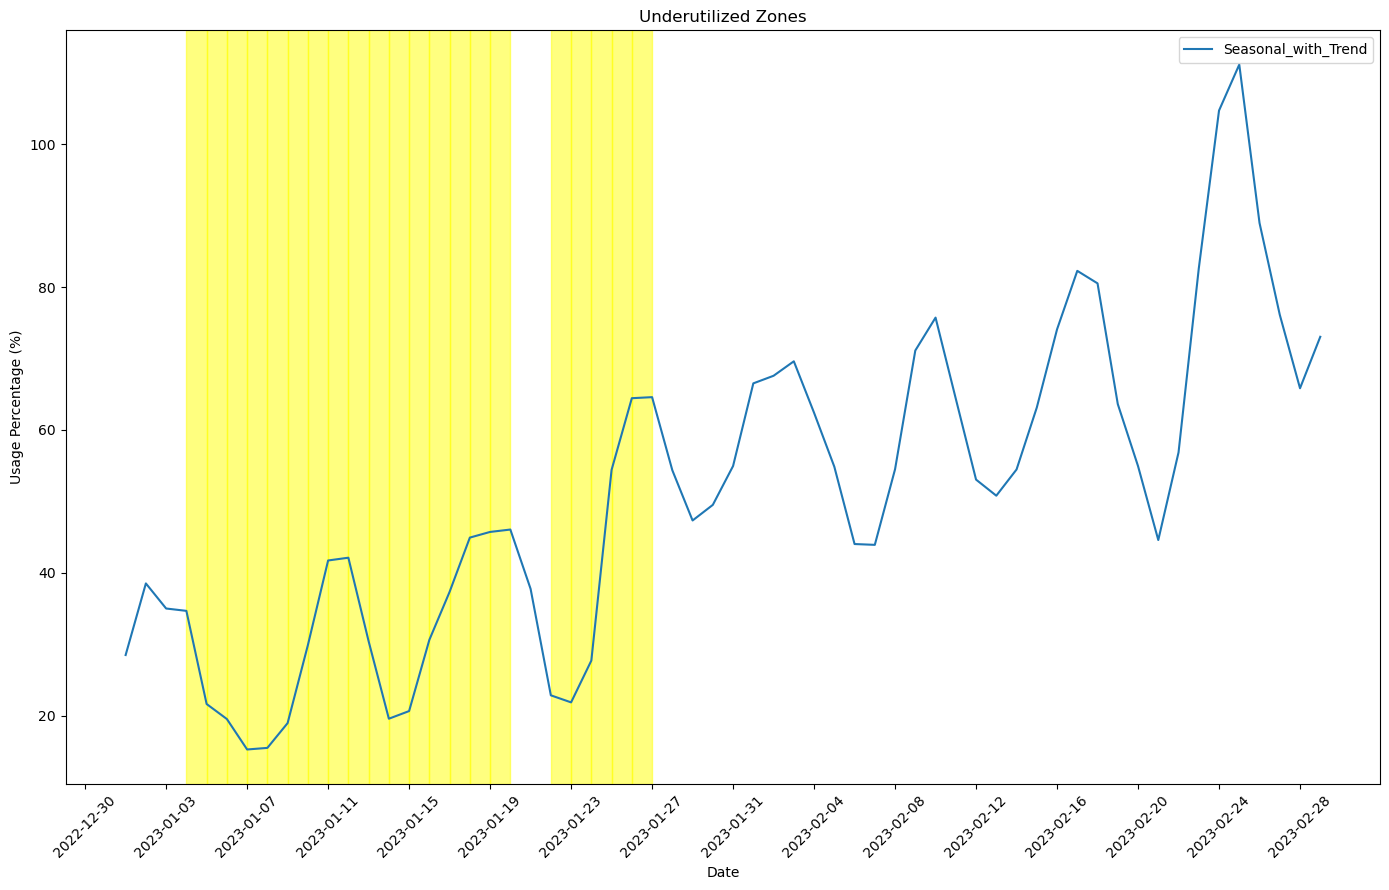

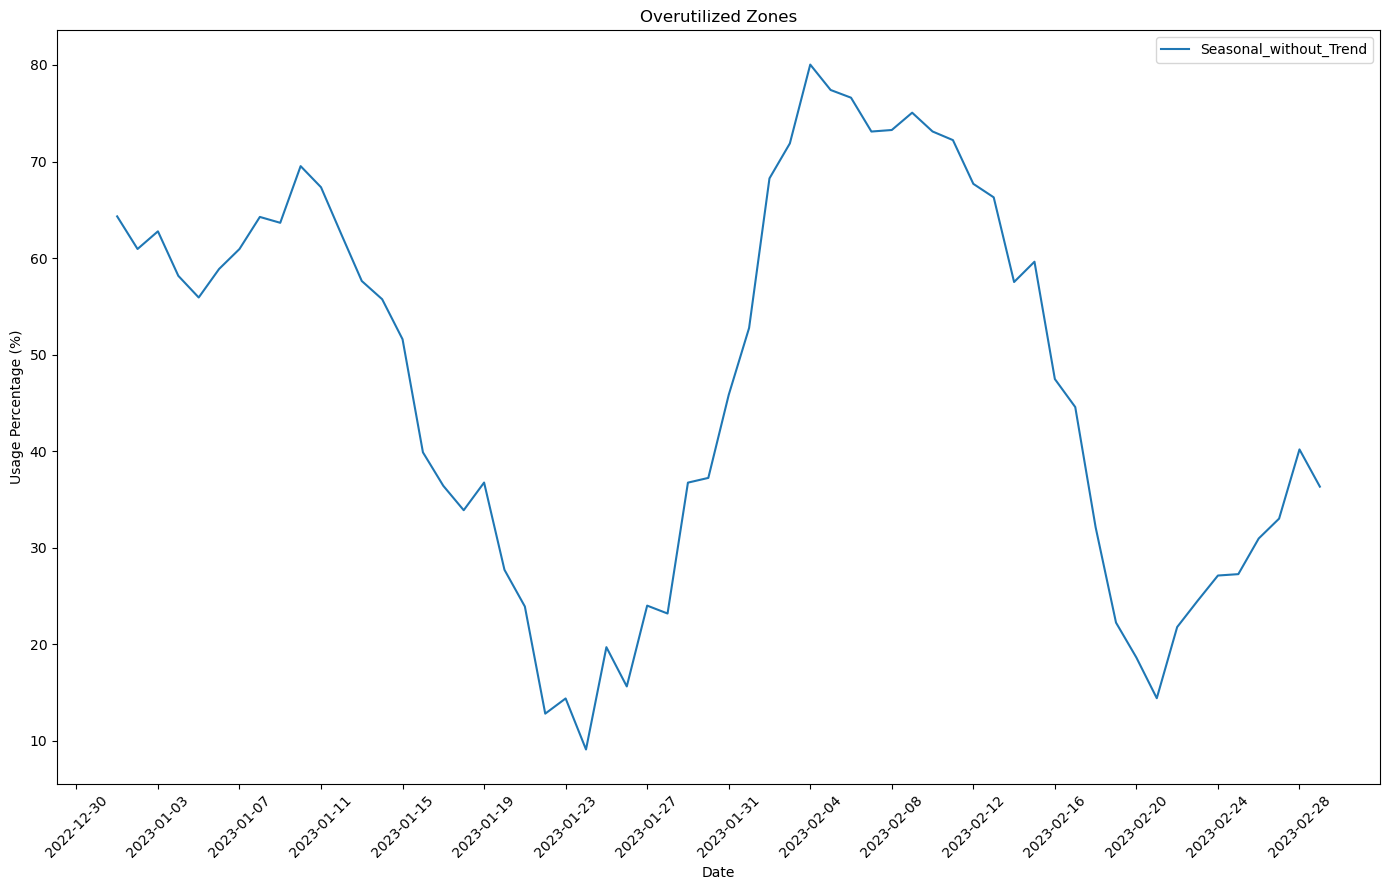

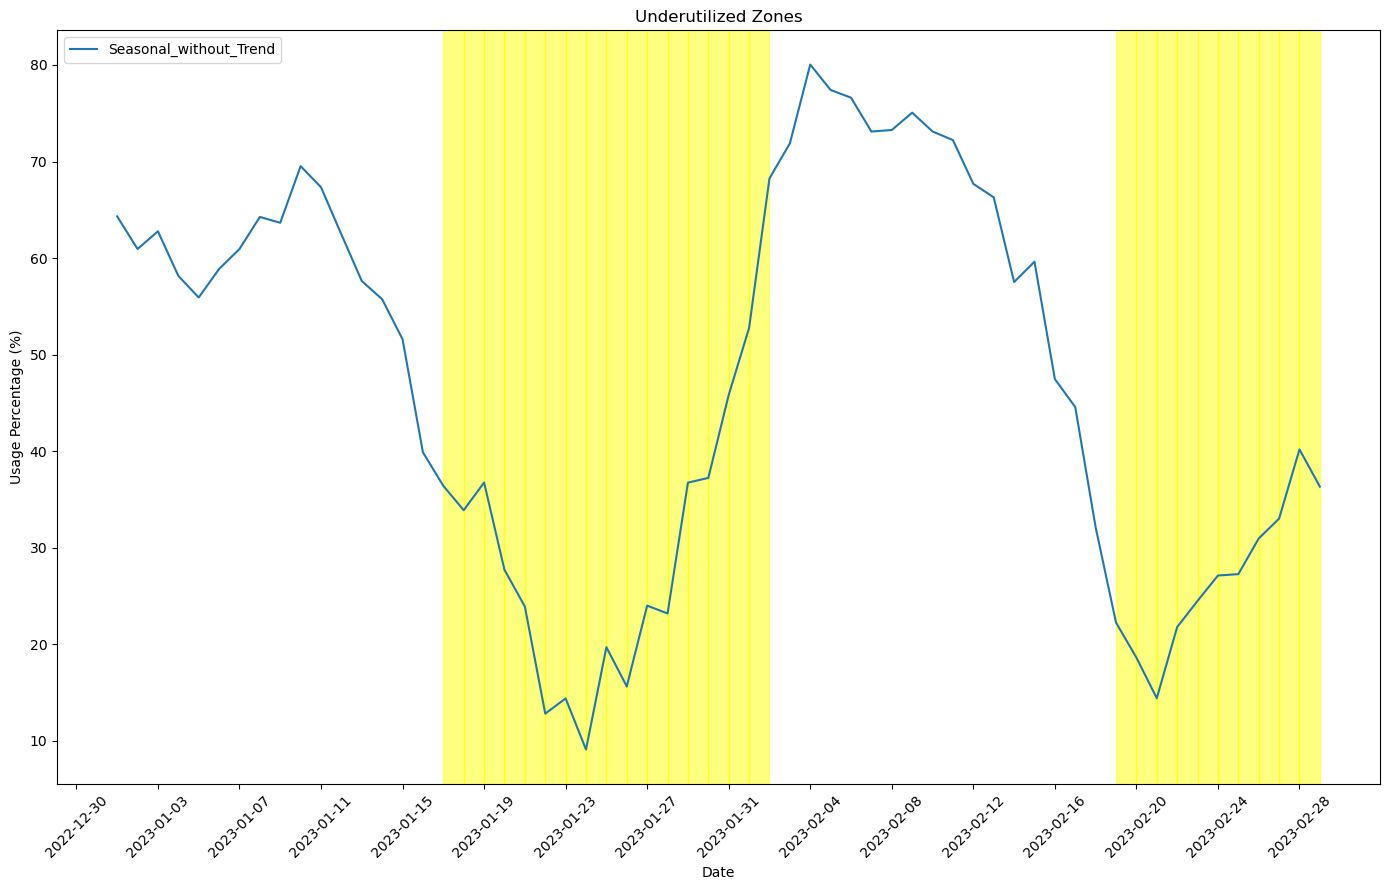

In [33]:
for col in original_cols:
    columns_and_labels = [('smoothed_' + col, col)]
    plot_with_highlights(df_simulated, columns_and_labels, 'overutilized_smoothed_'+col, 
                         xlabel='Date', ylabel='Usage Percentage (%)', title='Overutilized Zones', highlight_color='orange')

    plot_with_highlights(df_simulated, columns_and_labels, 'underutilized_smoothed_'+col, 
                         xlabel='Date', ylabel='Usage Percentage (%)', title='Underutilized Zones', highlight_color='yellow')